## Imports

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
import xgboost as xgb

In [25]:
import mlflow

#mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("nyc-taxi-experiment")

2022/06/10 19:46:56 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='./artifacts_local/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [5]:
def read_data(filename):
    df = pd.read_parquet(filename)
    
    categories_columns = ['PULocationID', 'DOLocationID']
    df[categories_columns] = df[categories_columns].astype('str')
    
    df['duration'] = df['lpep_dropoff_datetime'] -  df['lpep_pickup_datetime']
    
    df['duration'] = (df['duration'].dt.seconds /60).astype('float64').round(4) # duration in minutes
    
    # just o get the same result --> but is probably wrong do this in validation data
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    return df

In [6]:
def select_data(data):
    
    data['PU_DO'] = data['PULocationID'] + '_' +data['DOLocationID']
    
    categories_columns = ['PU_DO']
    #categories_columns = ['PULocationID', 'DOLocationID']
    numerical_columns = ['trip_distance']
    
    dict_data = data[categories_columns + numerical_columns].to_dict(orient='records')
    
    return dict_data

## Train Data

In [7]:
train_path = '../../datasets/green_tripdata_2021-01.parquet'
df_train = read_data(train_path)

#df_train = df_train.loc[df_train['duration'].between(1,60)]

y_train = df_train['duration']

dict_train = select_data(df_train)
dv = DictVectorizer()
x_train = dv.fit_transform(dict_train)

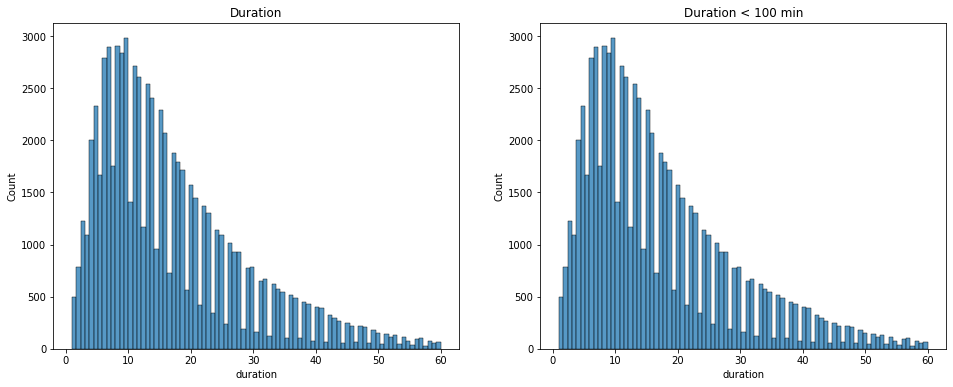

In [8]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(df_train['duration']).set_title('Duration')
plt.subplot(1,2,2)
sns.histplot(df_train.loc[df_train['duration']<100, 'duration']).set_title('Duration < 100 min');

## Validation Data

In [10]:
val_path = '../../datasets/green_tripdata_2021-02.parquet'
df_validation = read_data(val_path)

y_validation = df_validation['duration']

dict_validation = select_data(df_validation)

x_validation = dv.transform(dict_validation)

## Train and Evaluate Model

### LR MODEL

In [11]:
# define model
lr = LinearRegression()
# train model
lr.fit(x_train, y_train)
# predict on validation
y_predict = lr.predict(x_validation)

rmse = mean_squared_error(y_predict, y_validation, squared=False)
print(f'Mean Squared Errror: {rmse}')

print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')

Mean Squared Errror: 7.758715071950948
Mean Absolute Percentage Error: 0.4174608942923692


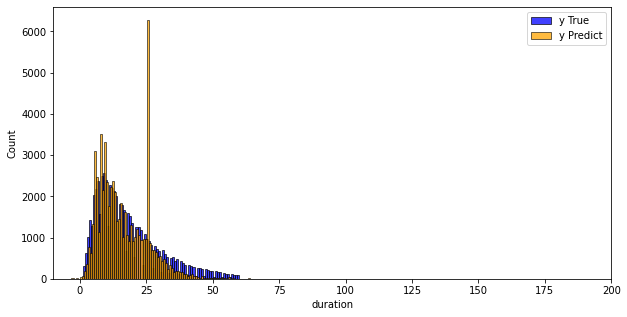

In [12]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Lasso

In [27]:
with mlflow.start_run(): 

    mlflow.set_tag("developer", "miguel")

    mlflow.log_param("train-data-path", train_path)
    mlflow.log_param("validation-data-path", val_path)

    alpha = 0.01

    mlflow.log_param("alpha", alpha)

    # define model
    lr = Lasso(alpha)
    # train model
    lr.fit(x_train, y_train)
    # predict on validation
    y_predict = lr.predict(x_validation)

    rmse = mean_squared_error(y_predict, y_validation, squared=False)

    mlflow.log_metric("rmse", rmse)
    print(f'Mean Squared Errror: {rmse}')

    print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')
    
    #mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

Mean Squared Errror: 11.16727583511989
Mean Absolute Percentage Error: 0.4807476874827497


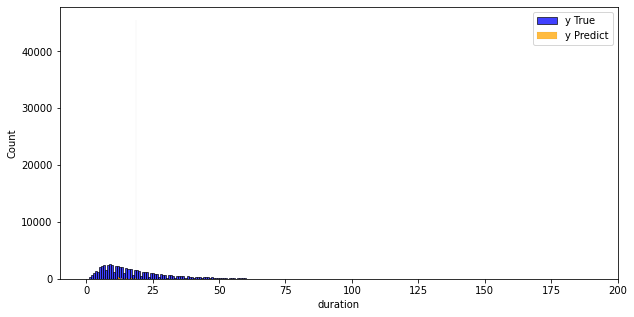

In [14]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Ridge

In [14]:
# define model
lr = Ridge(alpha=0.1)
# train model
lr.fit(x_train, y_train)
# predict on validation
y_predict = lr.predict(x_validation)

rmse = mean_squared_error(y_predict, y_validation, squared=False)
print(f'Mean Squared Errror: {rmse}')

print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')

Mean Squared Errror: 11.3425690614976
Mean Absolute Percentage Error: 0.6155785329763492


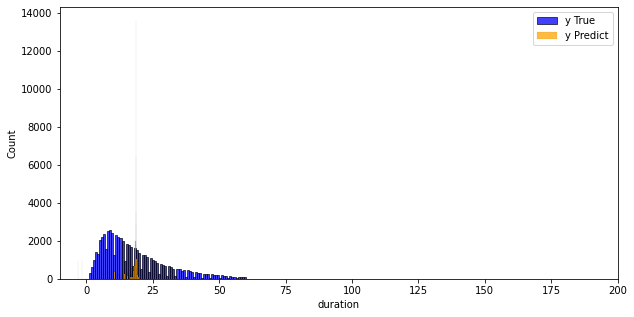

In [15]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Save Model

In [39]:
with open('models/lin_reg.bin', 'wb') as file:
    pickle.dump((dv, lr),file) # for now linear regression

## XGBoost

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_validation, label=y_validation)

In [17]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_validation, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [18]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[19:13:49] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.   
[0]	validation-rmse:16.06421                                                                                             
[1]	validation-rmse:12.60518                                                                                             
[2]	validation-rmse:10.32993                                                                                             
[3]	validation-rmse:8.87932                                                                                              
[4]	validation-rmse:7.97898                                                                                              
[5]	validation-rmse:7.42475                                                                                              
[6]	validation-rmse:7.08847                                                                                              
[7]	validation-rmse:6.88

[66]	validation-rmse:6.40204                                                                                             
[67]	validation-rmse:6.40129                                                                                             
[68]	validation-rmse:6.40010                                                                                             
[69]	validation-rmse:6.39939                                                                                             
[70]	validation-rmse:6.39901                                                                                             
[71]	validation-rmse:6.39759                                                                                             
[72]	validation-rmse:6.39665                                                                                             
[73]	validation-rmse:6.39530                                                                                             
[74]	validation-rmse:6.3

[133]	validation-rmse:6.38048                                                                                            
[134]	validation-rmse:6.38020                                                                                            
[135]	validation-rmse:6.38017                                                                                            
[136]	validation-rmse:6.38016                                                                                            
[137]	validation-rmse:6.38064                                                                                            
[138]	validation-rmse:6.38067                                                                                            
[139]	validation-rmse:6.38041                                                                                            
[140]	validation-rmse:6.38129                                                                                            
[141]	validation-rmse:6.

[28]	validation-rmse:6.85139                                                                                             
[29]	validation-rmse:6.83660                                                                                             
[30]	validation-rmse:6.82170                                                                                             
[31]	validation-rmse:6.81097                                                                                             
[32]	validation-rmse:6.80018                                                                                             
[33]	validation-rmse:6.79241                                                                                             
[34]	validation-rmse:6.78364                                                                                             
[35]	validation-rmse:6.77756                                                                                             
[36]	validation-rmse:6.7

[95]	validation-rmse:6.69430                                                                                             
[96]	validation-rmse:6.69390                                                                                             
[97]	validation-rmse:6.69306                                                                                             
[98]	validation-rmse:6.69235                                                                                             
[99]	validation-rmse:6.69194                                                                                             
[100]	validation-rmse:6.69128                                                                                            
[101]	validation-rmse:6.69097                                                                                            
[102]	validation-rmse:6.68954                                                                                            
[103]	validation-rmse:6.

[162]	validation-rmse:6.66431                                                                                            
[163]	validation-rmse:6.66378                                                                                            
[164]	validation-rmse:6.66341                                                                                            
[165]	validation-rmse:6.66299                                                                                            
[166]	validation-rmse:6.66267                                                                                            
[167]	validation-rmse:6.66090                                                                                            
[168]	validation-rmse:6.66060                                                                                            
[169]	validation-rmse:6.66029                                                                                            
[170]	validation-rmse:6.

[229]	validation-rmse:6.64228                                                                                            
[230]	validation-rmse:6.64217                                                                                            
[231]	validation-rmse:6.64192                                                                                            
[232]	validation-rmse:6.64166                                                                                            
[233]	validation-rmse:6.64141                                                                                            
[234]	validation-rmse:6.64078                                                                                            
[235]	validation-rmse:6.64058                                                                                            
[236]	validation-rmse:6.64016                                                                                            
[237]	validation-rmse:6.

[296]	validation-rmse:6.62463                                                                                            
[297]	validation-rmse:6.62438                                                                                            
[298]	validation-rmse:6.62417                                                                                            
[299]	validation-rmse:6.62400                                                                                            
[300]	validation-rmse:6.62369                                                                                            
[301]	validation-rmse:6.62351                                                                                            
[302]	validation-rmse:6.62337                                                                                            
[303]	validation-rmse:6.62312                                                                                            
[304]	validation-rmse:6.

[363]	validation-rmse:6.61153                                                                                            
[364]	validation-rmse:6.61142                                                                                            
[365]	validation-rmse:6.61132                                                                                            
[366]	validation-rmse:6.61125                                                                                            
[367]	validation-rmse:6.61109                                                                                            
[368]	validation-rmse:6.61104                                                                                            
[369]	validation-rmse:6.61087                                                                                            
[370]	validation-rmse:6.61081                                                                                            
[371]	validation-rmse:6.

[430]	validation-rmse:6.60040                                                                                            
[431]	validation-rmse:6.60027                                                                                            
[432]	validation-rmse:6.60014                                                                                            
[433]	validation-rmse:6.60016                                                                                            
[434]	validation-rmse:6.60004                                                                                            
[435]	validation-rmse:6.59992                                                                                            
[436]	validation-rmse:6.59978                                                                                            
[437]	validation-rmse:6.59958                                                                                            
[438]	validation-rmse:6.

[497]	validation-rmse:6.59161                                                                                            
[498]	validation-rmse:6.59156                                                                                            
[499]	validation-rmse:6.59104                                                                                            
[500]	validation-rmse:6.59077                                                                                            
[501]	validation-rmse:6.59075                                                                                            
[502]	validation-rmse:6.59065                                                                                            
[503]	validation-rmse:6.59059                                                                                            
[504]	validation-rmse:6.59057                                                                                            
[505]	validation-rmse:6.

[564]	validation-rmse:6.58432                                                                                            
[565]	validation-rmse:6.58429                                                                                            
[566]	validation-rmse:6.58423                                                                                            
[567]	validation-rmse:6.58425                                                                                            
[568]	validation-rmse:6.58423                                                                                            
[569]	validation-rmse:6.58412                                                                                            
[570]	validation-rmse:6.58405                                                                                            
[571]	validation-rmse:6.58394                                                                                            
[572]	validation-rmse:6.

[631]	validation-rmse:6.57739                                                                                            
[632]	validation-rmse:6.57727                                                                                            
[633]	validation-rmse:6.57724                                                                                            
[634]	validation-rmse:6.57715                                                                                            
[635]	validation-rmse:6.57687                                                                                            
[636]	validation-rmse:6.57677                                                                                            
[637]	validation-rmse:6.57667                                                                                            
[638]	validation-rmse:6.57657                                                                                            
[639]	validation-rmse:6.

[698]	validation-rmse:6.57157                                                                                            
[699]	validation-rmse:6.57139                                                                                            
[700]	validation-rmse:6.57129                                                                                            
[701]	validation-rmse:6.57124                                                                                            
[702]	validation-rmse:6.57115                                                                                            
[703]	validation-rmse:6.57110                                                                                            
[704]	validation-rmse:6.57110                                                                                            
[705]	validation-rmse:6.57107                                                                                            
[706]	validation-rmse:6.

[765]	validation-rmse:6.56615                                                                                            
[766]	validation-rmse:6.56609                                                                                            
[767]	validation-rmse:6.56595                                                                                            
[768]	validation-rmse:6.56583                                                                                            
[769]	validation-rmse:6.56580                                                                                            
[770]	validation-rmse:6.56585                                                                                            
[771]	validation-rmse:6.56579                                                                                            
[772]	validation-rmse:6.56573                                                                                            
[773]	validation-rmse:6.

[832]	validation-rmse:6.56257                                                                                            
[833]	validation-rmse:6.56255                                                                                            
[834]	validation-rmse:6.56252                                                                                            
[835]	validation-rmse:6.56243                                                                                            
[836]	validation-rmse:6.56238                                                                                            
[837]	validation-rmse:6.56237                                                                                            
[838]	validation-rmse:6.56235                                                                                            
[839]	validation-rmse:6.56231                                                                                            
[840]	validation-rmse:6.

[899]	validation-rmse:6.55821                                                                                            
[900]	validation-rmse:6.55826                                                                                            
[901]	validation-rmse:6.55816                                                                                            
[902]	validation-rmse:6.55810                                                                                            
[903]	validation-rmse:6.55805                                                                                            
[904]	validation-rmse:6.55801                                                                                            
[905]	validation-rmse:6.55795                                                                                            
[906]	validation-rmse:6.55791                                                                                            
[907]	validation-rmse:6.

[966]	validation-rmse:6.55545                                                                                            
[967]	validation-rmse:6.55536                                                                                            
[968]	validation-rmse:6.55528                                                                                            
[969]	validation-rmse:6.55521                                                                                            
[970]	validation-rmse:6.55513                                                                                            
[971]	validation-rmse:6.55511                                                                                            
[972]	validation-rmse:6.55514                                                                                            
[973]	validation-rmse:6.55506                                                                                            
[974]	validation-rmse:6.


KeyboardInterrupt



### Best Model + Auto MLflow

In [19]:
params = {'learning_rate':0.26171580843449055 ,
            'max_depth':17 ,
            'min_child_weight':int(1.8073685780167572) ,
            'objective': 'reg:linear',
            'reg_alpha': '0.20860267861726436',
            'reg_lambda': '0.3579871775866023',
            'seed':42
         }

In [20]:
mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
y_pred = booster.predict(valid)
rmse = mean_squared_error(y_validation, y_pred, squared=False)

mlflow.log_metric("rmse", rmse)

mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

2022/06/02 15:03:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f88f7b23080541bb8afe7dc3ac664c4f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[15:03:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.57998
[1]	validation-rmse:13.31840
[2]	validation-rmse:11.05628
[3]	validation-rmse:9.52573
[4]	validation-rmse:8.51473
[5]	validation-rmse:7.85748
[6]	validation-rmse:7.43240
[7]	validation-rmse:7.15410
[8]	validation-rmse:6.97736
[9]	validation-rmse:6.85831
[10]	validation-rmse:6.77803
[11]	validation-rmse:6.72543
[12]	validation-rmse:6.68628
[13]	validation-rmse:6.65905
[14]	validation-rmse:6.63890
[15]	validation-rmse:6.62345
[16]	validation-rmse:6.61327
[17]	validation-rmse:6.60681
[18]	validation-rmse:6.60250
[19]	validation-rmse:6.59701
[20]	validation-rmse:6.59253
[21]	validation-rmse:6.58811
[22]	validation-rmse:6.58234
[23]	validation-rmse:6.57881
[24]	validation-rmse:6.57606
[25]	validation-rmse:6.57376
[26]	validation-rmse:6.57199
[27]	validation-rmse:6.56877
[28]	validation-rmse:6.56711
[29]	validation-rmse:6.56502
[30]	validation-rm

[273]	validation-rmse:6.41624
[274]	validation-rmse:6.41622
[275]	validation-rmse:6.41583
[276]	validation-rmse:6.41617
[277]	validation-rmse:6.41600
[278]	validation-rmse:6.41495
[279]	validation-rmse:6.41482
[280]	validation-rmse:6.41451
[281]	validation-rmse:6.41462
[282]	validation-rmse:6.41425
[283]	validation-rmse:6.41389
[284]	validation-rmse:6.41394
[285]	validation-rmse:6.41317
[286]	validation-rmse:6.41286
[287]	validation-rmse:6.41253
[288]	validation-rmse:6.41207
[289]	validation-rmse:6.41182
[290]	validation-rmse:6.41156
[291]	validation-rmse:6.41133
[292]	validation-rmse:6.41077
[293]	validation-rmse:6.41101
[294]	validation-rmse:6.41059
[295]	validation-rmse:6.41030
[296]	validation-rmse:6.40985
[297]	validation-rmse:6.40946
[298]	validation-rmse:6.41008
[299]	validation-rmse:6.41055
[300]	validation-rmse:6.41053
[301]	validation-rmse:6.40994
[302]	validation-rmse:6.41008
[303]	validation-rmse:6.40942
[304]	validation-rmse:6.40886
[305]	validation-rmse:6.40854
[306]	vali

[547]	validation-rmse:6.36768
[548]	validation-rmse:6.36761
[549]	validation-rmse:6.36737
[550]	validation-rmse:6.36700
[551]	validation-rmse:6.36681
[552]	validation-rmse:6.36668
[553]	validation-rmse:6.36671
[554]	validation-rmse:6.36685
[555]	validation-rmse:6.36679
[556]	validation-rmse:6.36624
[557]	validation-rmse:6.36639
[558]	validation-rmse:6.36615
[559]	validation-rmse:6.36595
[560]	validation-rmse:6.36571
[561]	validation-rmse:6.36593
[562]	validation-rmse:6.36555
[563]	validation-rmse:6.36538
[564]	validation-rmse:6.36523
[565]	validation-rmse:6.36539
[566]	validation-rmse:6.36522
[567]	validation-rmse:6.36529
[568]	validation-rmse:6.36491
[569]	validation-rmse:6.36498
[570]	validation-rmse:6.36487
[571]	validation-rmse:6.36474
[572]	validation-rmse:6.36480
[573]	validation-rmse:6.36450
[574]	validation-rmse:6.36443
[575]	validation-rmse:6.36430
[576]	validation-rmse:6.36417
[577]	validation-rmse:6.36378
[578]	validation-rmse:6.36349
[579]	validation-rmse:6.36357
[580]	vali

[821]	validation-rmse:6.34799
[822]	validation-rmse:6.34771
[823]	validation-rmse:6.34774
[824]	validation-rmse:6.34754
[825]	validation-rmse:6.34777
[826]	validation-rmse:6.34768
[827]	validation-rmse:6.34744
[828]	validation-rmse:6.34739
[829]	validation-rmse:6.34744
[830]	validation-rmse:6.34764
[831]	validation-rmse:6.34739
[832]	validation-rmse:6.34735
[833]	validation-rmse:6.34733
[834]	validation-rmse:6.34671
[835]	validation-rmse:6.34667
[836]	validation-rmse:6.34656
[837]	validation-rmse:6.34661
[838]	validation-rmse:6.34631
[839]	validation-rmse:6.34630
[840]	validation-rmse:6.34644
[841]	validation-rmse:6.34641
[842]	validation-rmse:6.34661
[843]	validation-rmse:6.34673
[844]	validation-rmse:6.34739
[845]	validation-rmse:6.34722
[846]	validation-rmse:6.34717
[847]	validation-rmse:6.34719
[848]	validation-rmse:6.34726
[849]	validation-rmse:6.34728
[850]	validation-rmse:6.34685
[851]	validation-rmse:6.34689
[852]	validation-rmse:6.34680
[853]	validation-rmse:6.34666
[854]	vali

2022/06/02 15:04:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/miguelzph/anaconda3/envs/taxi_project/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


### Best Model + Manual MLflow + Pre Processing

In [31]:
mlflow.xgboost.autolog(disable=True)

In [26]:
with mlflow.start_run():
    
    mlflow.set_tag("model", "xgboost")
    
    best_params = {'learning_rate':0.26171580843449055 ,
            'max_depth':17 ,
            'min_child_weight':int(1.8073685780167572) ,
            'objective': 'reg:linear',
            'reg_alpha': '0.20860267861726436',
            'reg_lambda': '0.3579871775866023',
            'seed':42
         }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_validation, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)
    
    with open("dict_vectorizer.bin", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("dict_vectorizer.bin", artifact_path="preprocessor")

    
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

[19:47:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.57998
[1]	validation-rmse:13.31840
[2]	validation-rmse:11.05628
[3]	validation-rmse:9.52573
[4]	validation-rmse:8.51473
[5]	validation-rmse:7.85748
[6]	validation-rmse:7.43240
[7]	validation-rmse:7.15410
[8]	validation-rmse:6.97736
[9]	validation-rmse:6.85831
[10]	validation-rmse:6.77803
[11]	validation-rmse:6.72543
[12]	validation-rmse:6.68628
[13]	validation-rmse:6.65905
[14]	validation-rmse:6.63890
[15]	validation-rmse:6.62345
[16]	validation-rmse:6.61327
[17]	validation-rmse:6.60681
[18]	validation-rmse:6.60250
[19]	validation-rmse:6.59701
[20]	validation-rmse:6.59253
[21]	validation-rmse:6.58811
[22]	validation-rmse:6.58234
[23]	validation-rmse:6.57881
[24]	validation-rmse:6.57606
[25]	validation-rmse:6.57376
[26]	validation-rmse:6.57199
[27]	validation-rmse:6.56877
[28]	validation-rmse:6.56711
[29]	validation-rmse:6.56502
[30]	validation-rm

[273]	validation-rmse:6.41624
[274]	validation-rmse:6.41622
[275]	validation-rmse:6.41583
[276]	validation-rmse:6.41617
[277]	validation-rmse:6.41600
[278]	validation-rmse:6.41495
[279]	validation-rmse:6.41482
[280]	validation-rmse:6.41451
[281]	validation-rmse:6.41462
[282]	validation-rmse:6.41425
[283]	validation-rmse:6.41389
[284]	validation-rmse:6.41394
[285]	validation-rmse:6.41317
[286]	validation-rmse:6.41286
[287]	validation-rmse:6.41253
[288]	validation-rmse:6.41207
[289]	validation-rmse:6.41182
[290]	validation-rmse:6.41156
[291]	validation-rmse:6.41133
[292]	validation-rmse:6.41077
[293]	validation-rmse:6.41101
[294]	validation-rmse:6.41059
[295]	validation-rmse:6.41030
[296]	validation-rmse:6.40985
[297]	validation-rmse:6.40946
[298]	validation-rmse:6.41008
[299]	validation-rmse:6.41055
[300]	validation-rmse:6.41053
[301]	validation-rmse:6.40994
[302]	validation-rmse:6.41008
[303]	validation-rmse:6.40942
[304]	validation-rmse:6.40886
[305]	validation-rmse:6.40854
[306]	vali

[547]	validation-rmse:6.36768
[548]	validation-rmse:6.36761
[549]	validation-rmse:6.36737
[550]	validation-rmse:6.36700
[551]	validation-rmse:6.36681
[552]	validation-rmse:6.36668
[553]	validation-rmse:6.36671
[554]	validation-rmse:6.36685
[555]	validation-rmse:6.36679
[556]	validation-rmse:6.36624
[557]	validation-rmse:6.36639
[558]	validation-rmse:6.36615
[559]	validation-rmse:6.36595
[560]	validation-rmse:6.36571
[561]	validation-rmse:6.36593
[562]	validation-rmse:6.36555
[563]	validation-rmse:6.36538
[564]	validation-rmse:6.36523
[565]	validation-rmse:6.36539
[566]	validation-rmse:6.36522
[567]	validation-rmse:6.36529
[568]	validation-rmse:6.36491
[569]	validation-rmse:6.36498
[570]	validation-rmse:6.36487
[571]	validation-rmse:6.36474
[572]	validation-rmse:6.36480
[573]	validation-rmse:6.36450
[574]	validation-rmse:6.36443
[575]	validation-rmse:6.36430
[576]	validation-rmse:6.36417
[577]	validation-rmse:6.36378
[578]	validation-rmse:6.36349
[579]	validation-rmse:6.36357
[580]	vali

[821]	validation-rmse:6.34799
[822]	validation-rmse:6.34771
[823]	validation-rmse:6.34774
[824]	validation-rmse:6.34754
[825]	validation-rmse:6.34777
[826]	validation-rmse:6.34768
[827]	validation-rmse:6.34744
[828]	validation-rmse:6.34739
[829]	validation-rmse:6.34744
[830]	validation-rmse:6.34764
[831]	validation-rmse:6.34739
[832]	validation-rmse:6.34735
[833]	validation-rmse:6.34733
[834]	validation-rmse:6.34671
[835]	validation-rmse:6.34667
[836]	validation-rmse:6.34656
[837]	validation-rmse:6.34661
[838]	validation-rmse:6.34631
[839]	validation-rmse:6.34630
[840]	validation-rmse:6.34644
[841]	validation-rmse:6.34641
[842]	validation-rmse:6.34661
[843]	validation-rmse:6.34673
[844]	validation-rmse:6.34739
[845]	validation-rmse:6.34722
[846]	validation-rmse:6.34717
[847]	validation-rmse:6.34719
[848]	validation-rmse:6.34726
[849]	validation-rmse:6.34728
[850]	validation-rmse:6.34685
[851]	validation-rmse:6.34689
[852]	validation-rmse:6.34680
[853]	validation-rmse:6.34666
[854]	vali

### Prediction 

#### MLflowl + pyfunc  Model

In [35]:
#import mlflow
logged_model = 'runs:/ec83b5fdf5ef4ff5be337123791ffe4f/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
y_pred = loaded_model.predict(x_validation)

[21:16:55] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [36]:
mean_squared_error(y_validation, y_pred, squared=False)

6.345189935089873

#### XGboost Model

In [40]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[21:20:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
y_pred = xgboost_model.predict(xgb.DMatrix(x_validation))
mean_squared_error(y_validation, y_pred, squared=False)

6.345189935089873

## Other Models

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(x_train, y_train)

        y_pred = mlmodel.predict(x_validation)
        rmse = mean_squared_error(y_validation, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
 

2022/06/02 15:06:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
/home/miguelzph/anaconda3/envs/taxi_project/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
import mlflow
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = 'http://127.0.0.1:5000'
RUN_ID = 'f6705545dd7a4d97910dcf24be62b0de'

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

# dict vectorizer
path_dv = client.download_artifacts(run_id=RUN_ID,
                          path='preprocessor/dict_vectorizer.bin')

with open(path_dv, 'rb') as f_in:
    dv = pickle.load(f_in)

# model 
logged_model = f'runs:/{RUN_ID}/models_mlflow'

model = mlflow.pyfunc.load_model(logged_model)

[19:33:56] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
dv

DictVectorizer()